# TP: Machine Learning (SIA_3611)

## TP4: AutoML (4h) 

by Guillaume Renton 

In previous TP, you have learned to use machine learning for different kind of tasks, from regression to clustering through classification. In this TP, you are going to use the earned knowledge on new datasets for regression and classification. 

You are going to use 2 new datasets in this TP. First one is california housing, whose target variable is the value of houses in california, expressed in hundred of thousand of dollars. For each house, a set of 9 features is available. There is a total of 20 060 data. 

Second one is MNIST, a very popular dataset for handwritten recognition and image classification. The original dataset is made of 60 000 training images of shape 28x28 of handwritten digits from 0 to 9, and 10 000 images for test dataset. For computaional time, you will work on a given random subset of MNIST made of 6000 images in train and 1000 images in test.  

**Objectives :** 
- Apply your knowledge on new datasets
- Tune models hyperparameters and explore metrics 
- Apply principal components analysis and understand its effects on both dataset
- Understand and use Cross-Validation
- Use AutoML to find interesting models 

### STEP 1 : Getting started with new datasets

#### Substep 1 : Regression

In first part of step 1, you will work on the regression problem with the dataset california housing.

**To do 1.1**

Execute the following cell to load the california housing dataset and normalize it.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import normalize

X, y = fetch_california_housing(return_X_y = True)
X = normalize(X)

**To code 1.2**

Apply [Stochastic Gradient Descent](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor) and [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) methods and cross validate your results using 5 folders. For this, you can either use the function [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)(or any other method for cross validation in sklearn) or either compute yourself the cross validation. According to a relevant metric optimize both methods. For SGD you will optimize the value of alpha for both L2 and L1 penalty score. For SVR, you will optimize the kernel. Be careful with the metric if you use cross_val_score, the returned values are often negative.

In [17]:
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

In [20]:
# Creating an SGDRegressor
sgd = SGDRegressor()

# Parameter grid to optimize alpha and penalty
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2', 'l1'],
}

# Creating a custom scoring function for cross_val_score to handle negative values
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Use cross_val_score for hyperparameter optimization
grid_search_results = []
for alpha in param_grid['alpha']:
    for penalty in param_grid['penalty']:
        sgd.alpha = alpha
        sgd.penalty = penalty
        scores = -cross_val_score(sgd, X, y, cv=5, scoring=scorer)
        mean_score = scores.mean()
        grid_search_results.append((alpha, penalty, mean_score))

# Looking for the best hyperparameters based on the minimum mean score
best_alpha, best_penalty, best_score = min(grid_search_results, key=lambda x: x[2])

# Training the best model on the entire dataset
sgd.alpha = best_alpha
sgd.penalty = best_penalty
sgd.fit(X, y)

# Evaluating the best model with a relevant metric
y_pred = sgd.predict(X)
mae = mean_absolute_error(y, y_pred)
print(f"Best Alpha: {best_alpha}, Best Penalty: {best_penalty}")
#print(f"y_pred: {y_pred}")
print(f"Mean Absolute Error for SGD: {mae}")

Best Alpha: 0.0001, Best Penalty: l1
Mean Absolute Error for SGD: 0.9099619944202404


In [21]:
# Creating an SVR
svr = SVR()

# Parameter grid to optimize the kernel
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

# Creating a custom scoring function for cross_val_score to handle negative values
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Use cross_val_score for hyperparameter optimization
grid_search_results = []
for kernel in param_grid['kernel']:
    svr.kernel = kernel
    scores = -cross_val_score(svr, X, y, cv=5, scoring=scorer)
    mean_score = scores.mean()
    grid_search_results.append((kernel, mean_score))

# Finding the best kernel based on the minimum mean score
best_kernel, best_score = min(grid_search_results, key=lambda x: x[1])

# Training the best model on the entire dataset
svr.kernel = best_kernel
svr.fit(X, y)

# Evaluating the best model with a relevant metric
y_pred = svr.predict(X)
mae = mean_absolute_error(y, y_pred)
print(f"Best Kernel: {best_kernel}")
print(f"Mean Absolute Error: {mae}")

Best Kernel: poly
Mean Absolute Error: 0.787150063565576


**Question 1**

According to your metric, which method obtain the best result ? 

In terms of the mean absolute error metric, the Support Vector Regression (SVR) method with the polynomial kernel obtains the better result. It has a lower MAE of approximately 0.78715, which suggests it provides more accurate predictions compared to the Stochastic Gradient Descent (SGD) method with an MAE of approximately 0.90996.

**Question 2**

What is the interest of using cross validation in general ? Is it relevant in this particular case ?

Cross-validation is a crucial technique in machine learning for model evaluation, selection, and assessing generalization performance. Its primary purpose is to estimate how well a model will perform on an independent dataset, making it a valuable tool for both model development and hyperparameter tuning.

Yes, it's relevant in this particular case. In the case of optimizing hyperparameters for regression models like Stochastic Gradient Descent (SGD) and Support Vector Regression (SVR), cross-validation is highly relevant and beneficial

**To code 1.3**

Transform your data according to [principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), and optimize the number of components according to the same metric than previously for both models.

In [18]:
# Applying PCA to the data
n_components_list = range(1, 9)  # Adjust the range as needed
mae_sgd_pca = []

for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Creating an SGDRegressor model
    sgd = SGDRegressor()

    # Custom scoring function to handle negative values
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Create a pipeline with standardization and SGD
    sgd_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the data
        ('sgd', sgd)  # SGD model
    ])
    
    # Perform 5-fold cross-validation with the PCA-transformed data
    scores = -cross_val_score(sgd_pipeline, X_pca, y, cv=5, scoring=scorer)
    mean_score = np.mean(scores)
    
    mae_sgd_pca.append(mean_score)

# Find the best number of components based on the minimum mean score
best_n_components_sgd = n_components_list[np.argmin(mae_sgd_pca)]
best_mae_sgd = np.min(mae_sgd_pca)

print(f"Best Number of PCA Components for SGD: {best_n_components_sgd}")
print(f"Mean Absolute Error (SGD): {best_mae_sgd}")

Best Number of PCA Components for SGD: 8
Mean Absolute Error (SGD): 0.7881216099860717


In [22]:
# Apply PCA to the data
n_components_list = range(1, 9)  # Adjust the range as needed
mae_svr_pca = []

for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Create an SVR model
    svr = SVR()

    # Define a custom scoring function to handle negative values
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Create a pipeline with standardization and SVR
    svr_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the data
        ('svr', svr)  # SVR model
    ])
    
    # Perform 5-fold cross-validation with the PCA-transformed data
    scores = -cross_val_score(svr_pipeline, X_pca, y, cv=5, scoring=scorer)
    mean_score = np.mean(scores)
    
    mae_svr_pca.append(mean_score)

# Find the best number of components based on the minimum mean score
best_n_components_svr = n_components_list[np.argmin(mae_svr_pca)]
best_mae_svr = np.min(mae_svr_pca)

print(f"Best Number of PCA Components for SVR: {best_n_components_svr}")
print(f"Mean Absolute Error (SVR): {best_mae_svr}")

Best Number of PCA Components for SVR: 8
Mean Absolute Error (SVR): 0.5136822920816337


**Question 3**

What is the interest of Principal Component Analysis in general ? Is it relevant here ?

Principal Component Analysis (PCA) is a dimensionality reduction technique commonly used in machine learning and data analysis. Its primary objective is to reduce the dimensionality of a dataset while preserving the most important information or variance.

For SGD, the MAE with PCA is 0.7881216099860717.
For SVR, the MAE with PCA is 0.5136822920816337.
PCA was relevant in this context because it helped reduce the dimensionality of the feature space while retaining the most important information. In the case of SVR, PCA seems to have significantly improved the model's performance, as evidenced by the lower MAE. For SGD, PCA also provided dimensionality reduction, but the improvement in MAE is less substantial.

#### Substep 2 : Classification

**To do 1.4**

Execute the following cells to load a subset of MNIST dataset. Since the dataset is already divided into training/test, we won't use cross validation this time.

In [26]:
import pickle
with open("C:\\Users\\hp\\Desktop\\3A-SIA\\ML\\mnist.pkl", "rb") as f:
    ((X_train, y_train), (X_test, y_test)) = pickle.load(f)

**To code 1.5**

Compute classification on those images using a [KNN classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) and an [Adaboost classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). For each classifier, optimize the parameters according to a relevant metric. For the KNN classifier, you will optimize the number of neighbor while for the Adaboost classifier, you will optimize the base estimator along with the number of estimators (for the basis estimator, limit yourself to different depth of decision tree classifier). 

Also, for each model, compute the confusion matrix.

In [38]:
!pip install seaborn

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [31]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Define the parameter grid for optimization (e.g., varying the number of neighbors)
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]  # Adjust the range as needed
}

# Use GridSearchCV to find the best number of neighbors based on accuracy
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best KNN model with optimized parameters
best_knn = grid_search.best_estimator_

# Evaluate the best KNN model on the test data
y_pred_knn = best_knn.predict(X_test)

# Compute the confusion matrix for KNN
knn_confusion_matrix = confusion_matrix(y_test, y_pred_knn)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

# Print the best number of neighbors and accuracy
print("Best Number of Neighbors for KNN:", best_knn.n_neighbors)
print("Accuracy for KNN:", knn_accuracy)


Best Number of Neighbors for KNN: 3
Accuracy for KNN: 0.913


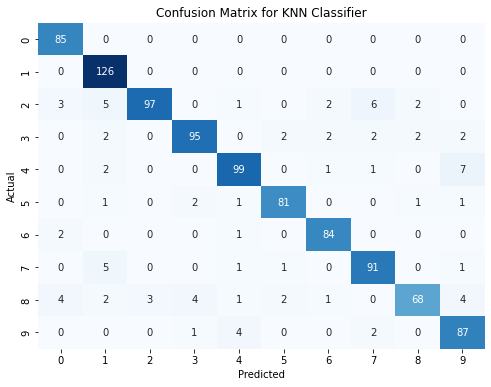

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix for KNN
knn_confusion_matrix = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

In [34]:
# Create a base estimator (decision tree) with different depths
base_estimators = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]

# Define the parameter grid for optimization (base estimator and number of estimators)
param_grid = {
    'base_estimator': base_estimators,
    'n_estimators': [50, 100, 200]  # Adjust the number of estimators as needed
}

# Create an AdaBoost classifier
adaboost = AdaBoostClassifier()

# Use GridSearchCV to find the best parameters for AdaBoost
grid_search = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best AdaBoost model with optimized parameters
best_adaboost = grid_search.best_estimator_

# Evaluate the best AdaBoost model on the test data
y_pred_adaboost = best_adaboost.predict(X_test)

# Compute the confusion matrix for AdaBoost
adaboost_confusion_matrix = confusion_matrix(y_test, y_pred_adaboost)
adaboost_accuracy = accuracy_score(y_test, y_pred_adaboost)

# Print the best parameters and accuracy for AdaBoost
print("Best Base Estimator for AdaBoost:", best_adaboost.base_estimator)
print("Best Number of Estimators for AdaBoost:", best_adaboost.n_estimators)
print("Accuracy for AdaBoost:", adaboost_accuracy)

Best Base Estimator for AdaBoost: DecisionTreeClassifier(max_depth=2)
Best Number of Estimators for AdaBoost: 200
Accuracy for AdaBoost: 0.569


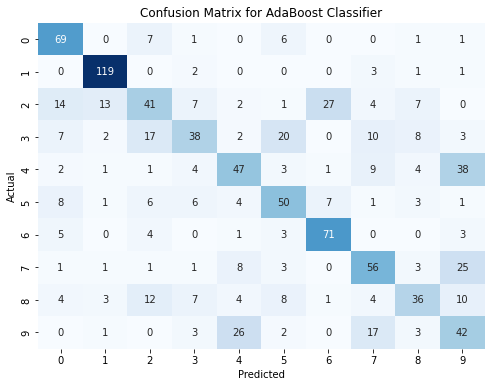

In [40]:
# Compute the confusion matrix for AdaBoost
adaboost_confusion_matrix = confusion_matrix(y_test, y_pred_adaboost)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(adaboost_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost Classifier')
plt.show()


**Question 4**

According to your metric, which method obtain the best results ? 

KNN with 3 neighbors 

Based on the provided metrics (accuracy), the K-Nearest Neighbors (KNN) classifier achieved a higher accuracy compared to the AdaBoost classifier. The accuracy achieved by the KNN classifier is approximately 0.913, while the accuracy of the AdaBoost classifier is approximately 0.569.

Therefore, according to the accuracy metric, the KNN classifier obtained the best results in this particular case. It correctly classified a higher proportion of instances in the test dataset compared to the AdaBoost classifier.

**Question 5**

According to the confusion matrix, which class if the easiest to classify ? Which ones are the most difficult ? Which ones are the most confused with each other ?

According to the confusion matrix, the class 1 is the easiest to classify.
The most difficult are: 

For KNN: 
 "8"
 
For AdaBoost:
 "2,3,4,5,7,8,9"

**Bonus** 

For the Adaboost classifier, explore other classifier as base estimators. What are the limitations about those estimators ?

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load a sample dataset (e.g., Iris dataset)
data = load_iris()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of base estimators to explore
base_estimators = [
    ('Logistic Regression', LogisticRegression()),
    ('SVM', SVC(kernel='linear')),
    ('Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=3))
]

# Iterate through the base estimators and evaluate their performance
for name, base_estimator in base_estimators:
    # Create an AdaBoost classifier with the current base estimator
    adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)

    # Train the AdaBoost classifier
    adaboost.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = adaboost.predict(X_test)

    # Calculate accuracy as the evaluation metric
    accuracy = accuracy_score(y_test, y_pred)

    # Print the performance of the current base estimator
    print(f'Base Estimator: {name}, Accuracy: {accuracy:.2f}')



**To code 1.6**

Transform your data according to principal component analysis, and optimize the number of components according to the same metric than previously for each classifier.

Once again, compute the confusion matrix for each model. 

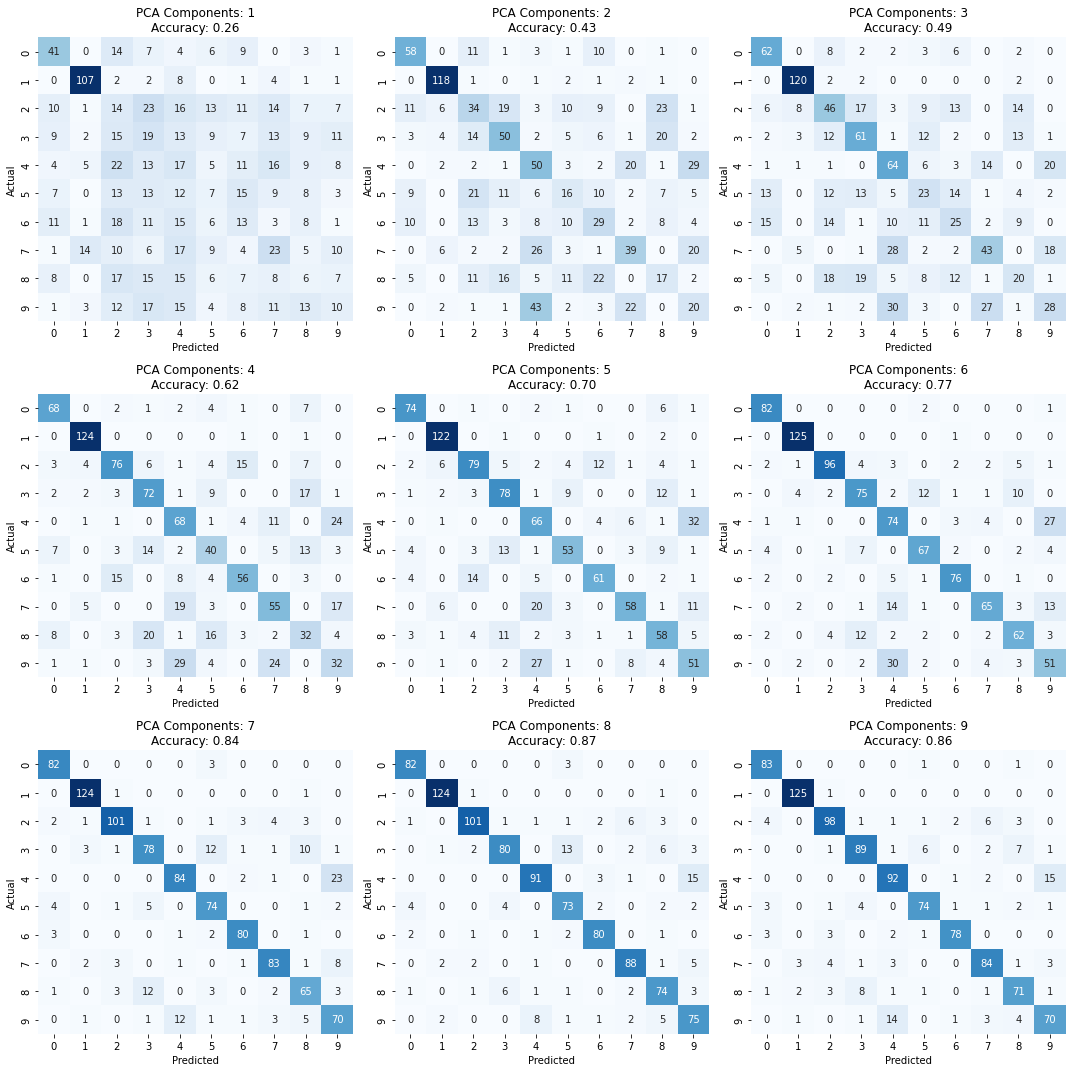

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of PCA components to explore
n_components = range(1, 10)

# Creating a PCA instance
pca = PCA()

# Lists to store the best KNN models with optimized components
best_knn_models = []

# Number of rows needed based on the number of components 
num_plots = len(n_components)
num_rows = (num_plots + 2) // 3  # Ensure at least 3 plots per row

# Create subplots with a maximum of 3 columns
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Iterate through the number of PCA components
for i, n in enumerate(n_components):
    # Calculate the current row and column for the subplot
    row = i // 3
    col = i % 3

    # Transform the data using PCA
    X_train_pca = pca.fit_transform(X_train)[:, :n]
    X_test_pca = pca.transform(X_test)[:, :n]

    # Optimize K-Nearest Neighbors (KNN) with PCA
    knn = KNeighborsClassifier()
    param_grid_knn = {
        'n_neighbors': [3, 5, 7]  
    }
    grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
    grid_search_knn.fit(X_train_pca, y_train)
    best_knn = grid_search_knn.best_estimator_
    best_knn_models.append(best_knn)

    # Predictions and performance for K-Nearest Neighbors (KNN)
    best_knn = best_knn_models[i]
    y_pred_knn = best_knn.predict(X_test_pca)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)

    # Visualize the confusion matrix for KNN using Seaborn in the corresponding subplot
    sns.heatmap(confusion_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')
    axes[row, col].set_title(f'PCA Components: {n}\nAccuracy: {accuracy_knn:.2f}')

# Removing empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i // 3, i % 3])


plt.tight_layout()
plt.show()


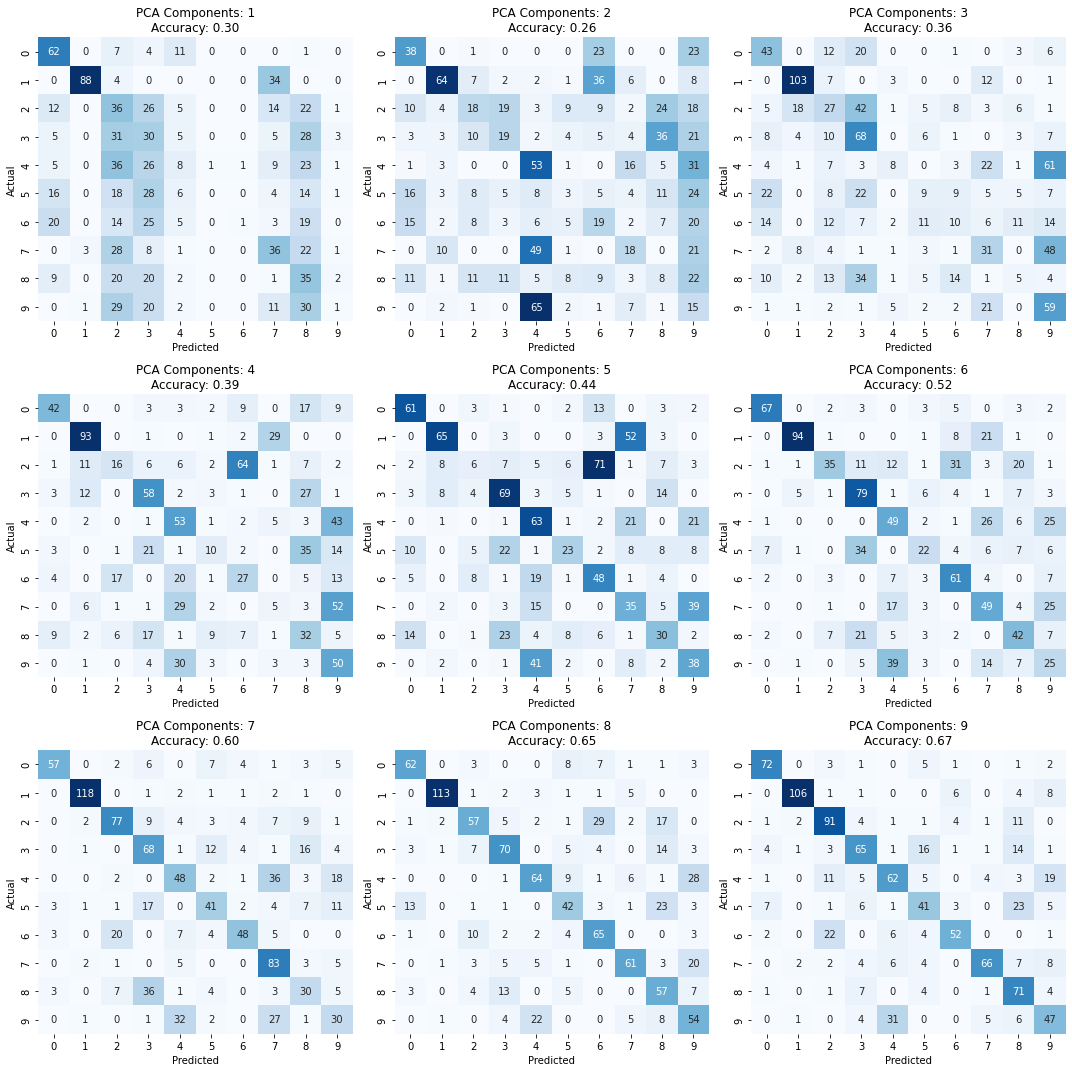

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of PCA components to explore
n_components = range(1, 10)

# Creating a PCA instance
pca = PCA()

# Lists to store the best AdaBoost models with optimized components
best_adaboost_models = []

# Calculate the number of rows needed based on the number of components and the maximum columns (3)
num_plots = len(n_components)
num_rows = (num_plots + 2) // 3  # Ensure at least 3 plots per row

# Create subplots with a maximum of 3 columns
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Iterate through the number of PCA components
for i, n in enumerate(n_components):
    # Calculate the current row and column for the subplot
    row = i // 3
    col = i % 3

    # Transform the data using PCA
    X_train_pca = pca.fit_transform(X_train)[:, :n]
    X_test_pca = pca.transform(X_test)[:, :n]

    # Optimize AdaBoost with PCA
    adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2))
    param_grid_adaboost = {
        'n_estimators': [50, 100, 200]  # Adjust the number of estimators as needed
    }
    grid_search_adaboost = GridSearchCV(adaboost, param_grid_adaboost, cv=5, scoring='accuracy')
    grid_search_adaboost.fit(X_train_pca, y_train)
    best_adaboost = grid_search_adaboost.best_estimator_
    best_adaboost_models.append(best_adaboost)

    # Predictions and performance for AdaBoost
    best_adaboost = best_adaboost_models[i]
    y_pred_adaboost = best_adaboost.predict(X_test_pca)
    accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
    confusion_matrix_adaboost = confusion_matrix(y_test, y_pred_adaboost)

    # Visualize the confusion matrix for AdaBoost using Seaborn in the corresponding subplot
    sns.heatmap(confusion_matrix_adaboost, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')
    axes[row, col].set_title(f'PCA Components: {n}\nAccuracy: {accuracy_adaboost:.2f}')

# Remove empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i // 3, i % 3])

# Adjust the layout
plt.tight_layout()
plt.show()


**Question 6**

Is the use of PCA relevant here ? 

According to the confusion matrix, the use of PCA is relevant here for KNN

**Question 7**

Did your answers from question 5 changed with PCA ?

No, it remain the same.

### Step 2 : AutoML

In this second section, we discuss on the utilisation of AutoMl tools, such as auto-sklearn.
If you are using colab or don't have auto-sklearn installed, you may need to run the following cell at first in order to install auto-sklearn. This will require you to restart the runtime (a prompt will invite you to). 

Restarting the runtime will clear all your variables and imported libraries, so you will need to import them again.

In [56]:
!pip install auto-sklearn
!pip install --force-reinstall scipy==1.6
!pip install --force-reinstall auto-sklearn==0.15.0

  Using cached auto-sklearn-0.15.0.tar.gz (6.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  Running setup.py clean for auto-sklearn
  Created wheel for pynisher: filename=pynisher-0.4.2-py3-none-any.whl size=4218 sha256=724da245942dee899daf3723d09b7c554b2797607f17217f6c351a29e4bb081c
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\aa\f5\90\bdee2c395e95702a631a8b2bc835fdaccb0cf333e0599b1d26


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\hp\anaconda3\python.exe' 'C:\Users\hp\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' get_requires_for_build_wheel 'C:\Users\hp\AppData\Local\Temp\tmp3b37yyxk'
       cwd: C:\Users\hp\AppData\Local\Temp\pip-install-a66083fh\auto-sklearn_2e2a1122598f477ca37a00f391189d0b
  Complete output (17 lines):
  Traceback (most recent call last):
    File "C:\Users\hp\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 349, in <module>
      main()
    File "C:\Users\hp\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 331, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
    File "C:\Users\hp\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 117, in get_requires_for_build_wheel
      return hook(config_settings)
    File "C:\Users\hp\AppData\Local\Temp\pip-build-env-wrx7fhtc\overlay\Lib\site-pack

  Running setup.py clean for pyrfr
  Running setup.py clean for scikit-learn
  Created wheel for smac: filename=smac-0.8.0-py3-none-any.whl size=97295 sha256=345f33806577fc630fdb75b8d3807fd6f20c77ac72ff6e85de67be7535c1d871
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\0e\f7\fe\d902e2c6589bfb41690838ad676c5d0a7907c7ee9a22da5a35
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11731 sha256=b3cd34119ed5f36c684a03ddbb0c204ca5979c4b11d8e6eb4aee63be70113ee5
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\08\82\8b\5c514221984e88c059b94e36a71d4722e590acaae04deab22e
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=168ec293f86c3b17ba82310ec4f05d7f0410a5587a5b60f289fde242426fe3c6
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\fa\17\1f\332799f975d1b2d7f9b3f33bbccf65031e794717d24432caee
Successfully built pynisher smac liac-arff typing
Failed to build auto-sklearn pyrfr scikit


  copying sklearn\datasets\tests\__init__.py -> build\lib.win-amd64-3.9\sklearn\datasets\tests
  creating build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\base.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\dict_learning.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\factor_analysis.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\fastica_.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\incremental_pca.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\kernel_pca.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\nmf.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\online_lda.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\pca.py -> build\lib.win-amd64-3.9\sklearn\decomposition
 

  Using cached scipy-1.6.0-cp39-cp39-win_amd64.whl (32.7 MB)
  Using cached numpy-1.26.1-cp39-cp39-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.0
    Uninstalling scipy-1.6.0:
      Successfully uninstalled scipy-1.6.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.26.1 which is incompatible.


  Using cached auto-sklearn-0.15.0.tar.gz (6.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\hp\anaconda3\python.exe' 'C:\Users\hp\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' get_requires_for_build_wheel 'C:\Users\hp\AppData\Local\Temp\tmpr8e5b3n4'
       cwd: C:\Users\hp\AppData\Local\Temp\pip-install-ti42ydli\auto-sklearn_571a70ff4a6c411a9f3f857f4d6b3648
  Complete output (17 lines):
  Traceback (most recent call last):
    File "C:\Users\hp\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 349, in <module>
      main()
    File "C:\Users\hp\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 331, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
    File "C:\Users\hp\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 117, in get_requires_for_build_wheel
      return hook(config_settings)
    File "C:\Users\hp\AppData\Local\Temp\pip-build-env-qt7vfqrz\overlay\Lib\site-pack

**To do 2.1**

Execute the following cells.  

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
X, y = fetch_california_housing(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
!pip install tpot

  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=d0fc982a6571b95c3eb6d56be71f45a3e80b213d0575acf03faf4087a22ae7e2
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\48\8c\93\3afb1916772591fe6bcc25cdf8b1c5bdc362f0ec8e2f0fd413
Successfully built stopit


In [9]:
import sklearn
print(sklearn.__version__)


0.24.2


In [10]:
#import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
#import os, shutil
from tpot import TPOTRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

#automl = autosklearn.regression.AutoSklearnRegressor(
#    include = {'regressor': ["libsvm_svr", "sgd"]},
#    time_left_for_this_task=120,
#    per_run_time_limit=30,
#    tmp_folder='/tmp/california_housing_tmp',
#)
#automl.fit(X_train, y_train, dataset_name='California_Housing')

#print(automl.leaderboard())

# Create a TPOTRegressor and specify the generations and population size
tpot = TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2)

# Fit the TPOTRegressor to the training data
tpot.fit(X_train, y_train)


#y_pred = automl.predict(X_test, y_test)
y_pred = tpot.predict(X_test)
print("MSE = ", mean_squared_error(y_test, y_pred))
print("MRE = ", mean_absolute_error(y_test, y_pred))

# Export the optimized pipeline as a Python script
tpot.export('tpot_california_housing_pipeline.py')

ImportError: cannot import name 'available_if' from 'sklearn.utils.metaestimators' (C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py)

In [ ]:
from pprint import pprint
pprint(automl.show_models(), indent=4)

**Question 8**

What are the evaluated models by autoML ? 
Which model obtain the best performance ? 
What are the parameters of the best model ?

**To code 2.2**

With the help of the previous code, use autoML for the classification task on MNIST, by limiting the exploration to KNN and Adaboost.

**Question 9**

What are the evaluated models by autoML ? 
Which model obtain the best performance ? 
What are the parameters of the best model ?

### Bonus step 

As a bonus step, have fun and remove a maximum of constraints of your autoML model. Which model obtain the best performances ? Describe the parameters of this model. You can do it for either for regression or classification or both.